In [1]:
import texthero as hero
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageColor
import colorsys
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# import lightgbm as lgbm
import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import nltk
import warnings

pd.set_option('display.max_Columns', 100)
warnings.simplefilter('ignore', UserWarning)

In [2]:
color = pd.read_csv('../input/color.csv')
color_rgb = pd.DataFrame(color['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), 
                         columns=['color_r', 'color_g', 'color_b'])
color = pd.concat([color, color_rgb], axis=1)
color['ratio'] = color['percentage']/100
print('color', color.shape)

color (73636, 7)


In [3]:
palette = pd.read_csv('../input/palette.csv')
print('palette', palette.shape)
material = pd.read_csv('../input/material.csv')
print('material', material.shape)
object_collection = pd.read_csv('../input/object_collection.csv')
print('object_collection', object_collection.shape)
technique = pd.read_csv('../input/technique.csv')
print('technique', technique.shape)
production_place = pd.read_csv('../input/production_place.csv')
print('production_place', production_place.shape)
production_country = pd.read_csv('../input/production_country.csv')
print('production_country', production_country.shape)
historical_person = pd.read_csv('../input/historical_person.csv')
print('historical_person', historical_person.shape)
maker = pd.read_csv('../input/maker.csv')
print('maker', maker.shape)
principal_maker = pd.read_csv('../input/principal_maker.csv')
print('principal_maker', principal_maker.shape)
principal_maker_occupation = pd.read_csv('../input/principal_maker_occupation.csv')
print('principal_maker_occupation', principal_maker_occupation.shape)
train = pd.read_csv('../input/train.csv')
print('train', train.shape)
test = pd.read_csv('../input/test.csv')
print('test', test.shape)
whole = pd.concat([train, test])
print('whole', whole.shape)

palette (527890, 5)
material (35394, 2)
object_collection (14210, 2)
technique (20481, 2)
production_place (17686, 2)
production_country (17686, 2)
historical_person (6745, 2)
maker (3291, 6)
principal_maker (24538, 6)
principal_maker_occupation (25372, 2)
train (12026, 19)
test (12008, 18)
whole (24034, 19)


### Text

In [4]:
def text_normalization(text):

    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

In [5]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [6]:
class TfidfBlock(AbstractBaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_topic=50):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_topic = n_topic

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def fit(self, input_df, y=None):
        text = self.preprocess(input_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=self.n_topic)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

In [7]:
def create_long_more_title(df_input):
    df_input['long_more_title'] = df_input['long_title'].str.cat(df_input['more_title'], sep=' ')

In [8]:
create_long_more_title(train)
create_long_more_title(test)
create_long_more_title(whole)

In [9]:
%%time
desc_block = TfidfBlock('description')
x = desc_block.fit(train)

title_block = TfidfBlock('title', 30)
x = title_block.fit(train)

longtitle_block = TfidfBlock('long_more_title')
x = longtitle_block.fit(train)

/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


CPU times: user 21.1 s, sys: 1.14 s, total: 22.3 s
Wall time: 19.1 s


In [10]:
def create_text_description_feature(df_input):
    return desc_block.transform(df_input)

def create_text_title_feature(df_input):
    return title_block.transform(df_input)

def create_text_longtitle_feature(df_input):
    return longtitle_block.transform(df_input)

#### Color

In [11]:
def rgb_to_h(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[0]

def rgb_to_s(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[1]

def rgb_to_v(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[2]

def get_total_color(color_input):
    cp = color_input.copy()
    cp['R'] = cp['color_r']*cp['ratio']/255
    cp['G'] = cp['color_g']*cp['ratio']/255
    cp['B'] = cp['color_b']*cp['ratio']/255
    rgb = cp.groupby('object_id').sum()[['R','G','B']]
    rgb['H'] = rgb.apply(rgb_to_h, axis=1)
    rgb['S'] = rgb.apply(rgb_to_s, axis=1)
    rgb['V'] = rgb.apply(rgb_to_v, axis=1)
    return rgb

main_color = get_total_color(color).add_prefix('color_').reset_index()
main_palette = get_total_color(palette).add_prefix('plt_').reset_index()

In [12]:
def create_main_color_feature(df_input):
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, main_color, on='object_id', how='left')
    cp = pd.merge(cp, main_palette, on='object_id', how='left')
    cp = cp.fillna(0).drop(columns=['object_id'])
    cp.index = df_input.index
    return cp

In [13]:
def get_color_count(df_input, color_input, col):
    color_cp = color_input[color_input['ratio'] > 0.05].copy()
    group = color_cp.groupby('object_id').size().rename(col).reset_index()
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, group, on='object_id', how='left').fillna(0)
    return cp[[col]]

def create_color_count_feature(df_input):
    color_count = get_color_count(df_input, color, 'color_count')
    color_count.index = df_input.index
    palette_count = get_color_count(df_input, palette, 'palette_count')
    palette_count.index = df_input.index
    return pd.concat([color_count, palette_count], axis=1)

In [14]:
def create_numeric_feature(df_input):
    cp = df_input.copy()
    cp['acquisition_year'] = pd.to_datetime(df_input['acquisition_date']).dt.year
    cp['dating_year_early_late'] = cp['dating_year_late'] - cp['dating_year_early'] + 1
    return cp[['acquisition_year', 'dating_sorting_date', 'dating_period', 'dating_year_early', 'dating_year_late', 'dating_year_early_late']]

#### principal_maker

In [15]:
def create_principal_maker_feature(df_input):
    occu_group = principal_maker_occupation.groupby('id').size().rename('occupation_count')
    occu_group = pd.DataFrame(occu_group).reset_index()
    
    maker_cp = pd.merge(principal_maker, occu_group, on='id', how='left')
    
    group = maker_cp.groupby('object_id').agg({'occupation_count':'sum', 'id':'size'}).reset_index()
    group.rename(columns={'id':'principal_maker_count'}, inplace=True)
    cp = pd.merge(df_input, group, on='object_id', how='left')
    return cp[['occupation_count', 'principal_maker_count']]

In [16]:
def create_maker_feature(df_input):
    maker_cp = maker.copy()
    maker_cp['birth_year'] = 0
    maker_cp.loc[maker_cp['date_of_birth'].notnull(), 'birth_year'] = maker_cp['date_of_birth']
    maker_cp['birth_year'] = maker_cp['birth_year'].apply(lambda x: str(x)[:4]).astype(int)
    
    maker_cp['death_year'] = 0
    maker_cp.loc[maker_cp['date_of_death'].notnull(), 'death_year'] = maker_cp['date_of_death']
    maker_cp['death_year'] = maker_cp['death_year'].apply(lambda x: str(x)[:4]).astype(int)

    maker_cp['maker_death_old'] = maker_cp['death_year'] - maker_cp['birth_year']
    maker_cp.rename(columns={'name': 'principal_maker'}, inplace=True)
    
    cp = pd.merge(df_input, maker_cp, on='principal_maker', how='left')
    return cp[['birth_year', 'death_year', 'maker_death_old']]

#### Count encoding

In [17]:
def create_count_encoding_feature_sub(df_whole, df_input, column):
    cp = df_input.copy()
    newcol = 'CE_'+column
    group = df_whole.groupby(column).size().rename(newcol)
    group = pd.DataFrame(group).reset_index()
    cp = pd.merge(cp, group, on=column, how='left')
    cp = cp[[newcol]].fillna(0)
    cp.index = df_input.index
    return cp

def create_count_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 'copyright_holder', 'acquisition_method', 
                'dating_sorting_date', 'dating_period']
    cp = df_input.copy()
    len_cp = len(cp)
    org_col = cp.columns
    for col in col_list:
        tmp = create_count_encoding_feature_sub(whole, cp, col)
        cp = pd.concat([cp, tmp], axis=1)
        assert len(cp) == len_cp
    return cp.drop(columns=org_col)

#### Label encoding

In [18]:
def create_label_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 'copyright_holder', 'acquisition_method']
    out_df = pd.DataFrame(index=df_input.index)
    le = LabelEncoder()
    for col in col_list:
        le.fit(whole[col])
        out_df[col] = le.transform(df_input[col])
    return out_df.add_prefix('LE_')

#### One-hot encoding

In [19]:
def get_one_hot_encoding(df_input, df_merge, count, prefix):
    value_counts = df_merge['name'].value_counts()
    col_list = list(value_counts.index[0:count])
    dummy = pd.get_dummies(df_merge['name'])[col_list]
    dummy = pd.concat([df_merge, dummy], axis=1)
    group = dummy.groupby('object_id').sum()
    group = group.add_prefix(prefix).reset_index()
    out = pd.merge(df_input[['object_id']], group, on='object_id', how='left')
    out = out.fillna(0).drop(columns=['object_id'])
    out.index = df_input.index
    return out

def creat_material_feature(df_input):
    return get_one_hot_encoding(df_input, material, 10, 'MT_')

def creat_object_collection_feature(df_input):
    return get_one_hot_encoding(df_input, object_collection, 3, 'OC_')

def creat_production_place_feature(df_input):
    return get_one_hot_encoding(df_input, production_place, 10, 'PP_')

def creat_production_country_feature(df_input):
    return get_one_hot_encoding(df_input, production_country, 17, 'PC_')

def creat_technique_feature(df_input):
    return get_one_hot_encoding(df_input, technique, 10, 'TC_')

def creat_historical_person_feature(df_input):
    ohe = get_one_hot_encoding(df_input, historical_person, 3, 'HP_')
    ohe.columns = ['HP_' + str(i) for i in range(len(ohe.columns))]
    return ohe

#### String length

In [20]:
def create_string_length_feature(df_input):
    out_df = pd.DataFrame()
    str_columns = ['title', 'long_title', 'sub_title', 'more_title', 'description']
    for c in str_columns:
        out_df[c] = df_input[c].str.len()
    return out_df.add_prefix('LN_')

In [21]:
def create_sub_title_feature(df_input):
    out = pd.DataFrame(index=df_input.index)
    out['dimension'] = 0
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = df_input['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis))
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float)
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) 
        out[column_name] = size_info[column_name]
        out['dimension'] += out[column_name].apply(lambda x: 0 if np.isnan(x) else 1)
    out['area'] = out['size_h'] * out['size_w']
    return out

#### Target encoding

In [22]:
def target_encoding(df_input, target_col, k_fold=5):
    encoding_col = 'TE_' + target_col
    X = df_input
    out = pd.DataFrame(index=X.index)
    out[encoding_col] = np.NaN

    if 'likes' in df_input.columns:
        # train
        cv = KFold(n_splits=k_fold, shuffle=True, random_state=0)
        for train_index, valid_index in cv.split(X):
            x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
            likes = x_train.groupby(target_col)[['likes']].mean().reset_index()
            tmp = pd.merge(x_valid[[target_col]], likes, on=[target_col], how='left')
            tmp.index = valid_index
            out.loc[valid_index, encoding_col] = tmp['likes'].apply(np.log1p)
    else:
        # test
        likes = train.groupby(target_col)[['likes']].mean().reset_index()
        tmp = pd.merge(X[[target_col]], likes, on=[target_col], how='left')
        out[encoding_col] = tmp['likes'].apply(np.log1p)
    return out

def creat_target_encoding_principal_maker(df_input):
    return target_encoding(df_input, 'principal_maker')

def creat_target_encoding_principal_or_first_maker(df_input):
    return target_encoding(df_input, 'principal_or_first_maker')

#### All feature

In [23]:
func_list = [
    create_text_description_feature,
    create_text_title_feature,
    create_text_longtitle_feature,
    create_numeric_feature,
    create_count_encoding_feature,
    create_label_encoding_feature,
    create_string_length_feature,
    create_sub_title_feature,
    creat_material_feature,
    creat_object_collection_feature,
    creat_production_place_feature,
    creat_production_country_feature,
    creat_technique_feature,
    creat_historical_person_feature,
    create_main_color_feature,
    create_color_count_feature,
    create_principal_maker_feature,
    create_maker_feature,
]

func_list_w_te = func_list + [
    creat_target_encoding_principal_maker,
    creat_target_encoding_principal_or_first_maker,
]

In [24]:
def create_all_feature(df_input, func_list):
    out = pd.DataFrame(index=df_input.index)
    for func in func_list:
        out = pd.concat([out, func(df_input)], axis=1)
        assert len(df_input) == len(out)
    return out

In [25]:
def split_train_target(df_input):
    target = df_input[['likes']].copy()
    target['target'] = target['likes'].apply(np.log1p)
    return target['target']

In [26]:
# LGBM_PARAMS = [
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 6.704427554963601e-05, 'lambda_l2': 0.2594818452171153, 'num_leaves': 31, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 43, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 8, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 71, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 3.055024366525963e-05, 'lambda_l2': 1.2402166045062701e-08, 'num_leaves': 70, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 97, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.2919048713607116e-07, 'lambda_l2': 0.39469524025144875, 'num_leaves': 73, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 119, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.2707018250248112e-08, 'lambda_l2': 1.0000381572720369e-08, 'num_leaves': 251, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
# ]
KFOLD = 5

In [27]:
LGBM_PARAMS = [
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
]

In [28]:
cat_feat = [
    'LE_art_series_id', 
    'LE_copyright_holder', 'LE_acquisition_method'
]

cat_feat_te = [
    'LE_principal_maker', 'LE_principal_or_first_maker', 
]

cat_feat_w_te = cat_feat + cat_feat_te

In [29]:
def get_stratified(y):
    y_bin = y.astype(int)
    y_bin[y_bin >=8] = 8
    return y_bin

In [30]:
#get_stratified(train_y1).value_counts()

In [31]:
def train_kfold(X, y, cat_feat, k_fold=KFOLD):
    rmse_list = []
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=0)
    cv_split = cv.split(X, get_stratified(y))
    
#     cv = KFold(n_splits=k_fold, shuffle=True, random_state=0)
#     cv_split = cv.split(X)

    for i, (train_index, valid_index) in enumerate(cv_split):

        x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        params = LGBM_PARAMS[i]

        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        lgbm_model = lgbm.train(params, 
                                                lgbm_train, 
                                                valid_sets=lgbm_eval,
                                                num_boost_round=10000,
                                                early_stopping_rounds=100,
                                                categorical_feature = cat_feat,
                                                verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        oof_pred[valid_index] = y_pred

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        rmse_list.append(rmse)
        models.append(lgbm_model)

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('- TRAIN RMSE={:.4f}'.format(score))

    return models, oof_pred, score

In [32]:
def predict_test(test_X, models):
    pred_list = []
    for model in models:
        pred = model.predict(test_X, num_iteration = model.best_iteration)
        pred_list.append(pred)
    pred_test = np.mean(pred_list, axis=0)
    return pred_test

In [33]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [34]:
train_X1 = create_all_feature(train, func_list_w_te)
test_X1 = create_all_feature(test, func_list_w_te)
train_y1 = split_train_target(train)
print(train_X1.shape)
print(train_y1.shape)
print(test_X1.shape)
feat_cnt1 = len(train_X1.columns)

/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


(12026, 233)
(12026,)
(12008, 233)


In [35]:
models1, oof_pred1, score1 = train_kfold(train_X1, train_y1, cat_feat_w_te)
pred1 = predict_test(test_X1, models1)
test_pred1 = revert_to_real(pred1)
print('test_pred1', len(test_pred1))
test_X1['likes'] = test_pred1

<ipython-input-31-a3aeb6a46d94>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)
[I 2021-03-10 02:35:16,682] A new study created in memory with name: no-name-a0492f26-f9e7-4b30-ba83-346f845f75cb
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.012249:  14%|#4        | 1/7 [00:07<00:46,  7.81s/it]

Early stopping, best iteration is:
[172]	valid_0's rmse: 1.01225
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.011699:  29%|##8       | 2/7 [00:15<00:39,  7.89s/it]

Early stopping, best iteration is:
[143]	valid_0's rmse: 1.0117
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.011699:  43%|####2     | 3/7 [00:23<00:31,  7.91s/it]

Early stopping, best iteration is:
[215]	valid_0's rmse: 1.01917
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.011699:  57%|#####7    | 4/7 [00:29<00:21,  7.06s/it]

Early stopping, best iteration is:
[216]	valid_0's rmse: 1.01696
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.011699:  71%|#######1  | 5/7 [00:36<00:13,  6.93s/it]

Early stopping, best iteration is:
[235]	valid_0's rmse: 1.01744
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.011699:  86%|########5 | 6/7 [00:42<00:06,  6.81s/it]

Early stopping, best iteration is:
[159]	valid_0's rmse: 1.01229
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.011699:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[124]	valid_0's rmse: 1.01353
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.009031:   5%|5         | 1/20 [00:14<04:34, 14.45s/it]

Early stopping, best iteration is:
[49]	valid_0's rmse: 1.00903
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  10%|#         | 2/20 [00:30<04:33, 15.19s/it]

Early stopping, best iteration is:
[161]	valid_0's rmse: 1.00518
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  15%|#5        | 3/20 [00:52<05:16, 18.62s/it]

Early stopping, best iteration is:
[32]	valid_0's rmse: 1.01844
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  20%|##        | 4/20 [01:24<06:23, 23.95s/it]

Early stopping, best iteration is:
[83]	valid_0's rmse: 1.0172
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  25%|##5       | 5/20 [01:35<04:46, 19.09s/it]

Early stopping, best iteration is:
[137]	valid_0's rmse: 1.01626
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  30%|###       | 6/20 [01:48<03:59, 17.08s/it]

Early stopping, best iteration is:
[62]	valid_0's rmse: 1.00895
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  35%|###5      | 7/20 [02:03<03:30, 16.22s/it]

Early stopping, best iteration is:
[84]	valid_0's rmse: 1.00795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.005176:  40%|####      | 8/20 [02:17<03:08, 15.71s/it]

Early stopping, best iteration is:
[61]	valid_0's rmse: 1.01019
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  45%|####5     | 9/20 [02:33<02:53, 15.78s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00222
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  50%|#####     | 10/20 [02:50<02:42, 16.21s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 1.01142
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  55%|#####5    | 11/20 [03:13<02:43, 18.18s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 1.01683
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  60%|######    | 12/20 [03:20<01:58, 14.79s/it]

Early stopping, best iteration is:
[565]	valid_0's rmse: 1.01935
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  65%|######5   | 13/20 [03:32<01:37, 13.93s/it]

Early stopping, best iteration is:
[162]	valid_0's rmse: 1.0176
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  70%|#######   | 14/20 [03:53<01:36, 16.15s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 1.02011
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  75%|#######5  | 15/20 [04:02<01:10, 14.02s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.01672
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  80%|########  | 16/20 [04:09<00:47, 11.83s/it]

Early stopping, best iteration is:
[565]	valid_0's rmse: 1.01935
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  85%|########5 | 17/20 [04:28<00:42, 14.03s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 1.01542
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  90%|######### | 18/20 [04:39<00:25, 12.99s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 1.0066
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.002222:  95%|#########5| 19/20 [05:20<00:21, 21.45s/it]

Early stopping, best iteration is:
[73]	valid_0's rmse: 1.01681
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[90]	valid_0's rmse: 1.01284
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  10%|#         | 1/10 [00:25<03:45, 25.02s/it]

Early stopping, best iteration is:
[71]	valid_0's rmse: 1.02201
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  20%|##        | 2/10 [00:44<02:54, 21.87s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 1.03701
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  30%|###       | 3/10 [01:04<02:26, 20.88s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 1.02603
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  40%|####      | 4/10 [01:20<01:54, 19.13s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 1.0211
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  50%|#####     | 5/10 [01:35<01:28, 17.66s/it]

Early stopping, best iteration is:
[46]	valid_0's rmse: 1.01984
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  60%|######    | 6/10 [01:51<01:07, 16.80s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 1.01234
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  70%|#######   | 7/10 [02:03<00:45, 15.30s/it]

Early stopping, best iteration is:
[31]	valid_0's rmse: 1.03178
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  80%|########  | 8/10 [02:19<00:31, 15.73s/it]

Early stopping, best iteration is:
[63]	valid_0's rmse: 1.03451
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.002222:  90%|######### | 9/10 [02:32<00:14, 14.88s/it]

Early stopping, best iteration is:
[41]	valid_0's rmse: 1.02842
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.002222:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[43]	valid_0's rmse: 1.02902
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.002222:  33%|###3      | 1/3 [00:13<00:27, 13.94s/it]

Early stopping, best iteration is:
[51]	valid_0's rmse: 1.01734
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.002222:  67%|######6   | 2/3 [00:31<00:16, 16.16s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 1.00767
Training until validation scores don't improve for 100 rounds


  0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[63]	valid_0's rmse: 1.01578


regularization_factors, val_score: 1.002222:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:   5%|5         | 1/20 [00:20<06:33, 20.71s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 1.01089
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  10%|#         | 2/20 [00:35<05:05, 16.97s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.00711
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  15%|#5        | 3/20 [00:52<04:49, 17.02s/it]

Early stopping, best iteration is:
[87]	valid_0's rmse: 1.01299
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  20%|##        | 4/20 [01:08<04:26, 16.65s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  25%|##5       | 5/20 [01:23<04:00, 16.02s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 1.01061
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  30%|###       | 6/20 [01:39<03:44, 16.03s/it]

Early stopping, best iteration is:
[73]	valid_0's rmse: 1.0106
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  35%|###5      | 7/20 [01:53<03:20, 15.44s/it]

Early stopping, best iteration is:
[49]	valid_0's rmse: 1.00915
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  40%|####      | 8/20 [02:13<03:21, 16.79s/it]

Early stopping, best iteration is:
[117]	valid_0's rmse: 1.01386
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  45%|####5     | 9/20 [02:29<03:04, 16.75s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 1.01173
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  50%|#####     | 10/20 [02:45<02:45, 16.51s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  55%|#####5    | 11/20 [03:01<02:26, 16.31s/it]

Early stopping, best iteration is:
[81]	valid_0's rmse: 1.01686
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  60%|######    | 12/20 [03:17<02:10, 16.32s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  65%|######5   | 13/20 [03:33<01:53, 16.24s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00232
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  70%|#######   | 14/20 [03:50<01:37, 16.27s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  75%|#######5  | 15/20 [04:06<01:21, 16.37s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00224
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  80%|########  | 16/20 [04:24<01:06, 16.63s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  85%|########5 | 17/20 [04:38<00:48, 16.09s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 1.00449
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  90%|######### | 18/20 [04:55<00:32, 16.13s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.00231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.002222:  95%|#########5| 19/20 [05:11<00:16, 16.24s/it]

Early stopping, best iteration is:
[77]	valid_0's rmse: 1.00311
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.002222:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[51]	valid_0's rmse: 1.01328
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.002222:  20%|##        | 1/5 [00:12<00:49, 12.40s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 1.01698
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.002222:  40%|####      | 2/5 [00:22<00:32, 10.84s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 1.01987
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.002222:  60%|######    | 3/5 [00:34<00:23, 11.65s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 1.02186
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.002222:  80%|########  | 4/5 [00:46<00:11, 11.57s/it]

Early stopping, best iteration is:
[63]	valid_0's rmse: 1.01218
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.002222: 100%|##########| 5/5 [01:02<00:00, 12.40s/it]

Early stopping, best iteration is:
[91]	valid_0's rmse: 1.01294



[I 2021-03-10 02:51:54,014] A new study created in memory with name: no-name-37dffb79-4f0b-4add-81ee-2f3a423c7bb8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.031160:  14%|#4        | 1/7 [00:09<00:56,  9.47s/it]

Early stopping, best iteration is:
[435]	valid_0's rmse: 1.03116
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.030418:  29%|##8       | 2/7 [00:19<00:48,  9.75s/it]

Early stopping, best iteration is:
[399]	valid_0's rmse: 1.03042
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.030418:  43%|####2     | 3/7 [00:24<00:30,  7.62s/it]

Early stopping, best iteration is:
[299]	valid_0's rmse: 1.04356
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.030418:  57%|#####7    | 4/7 [00:32<00:23,  7.79s/it]

Early stopping, best iteration is:
[399]	valid_0's rmse: 1.03601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[909]	valid_0's rmse: 1.03818


feature_fraction, val_score: 1.030418:  71%|#######1  | 5/7 [00:42<00:17,  8.52s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.028152:  86%|########5 | 6/7 [00:53<00:09,  9.24s/it]

Early stopping, best iteration is:
[622]	valid_0's rmse: 1.02815
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.028152:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[618]	valid_0's rmse: 1.03099
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.028152:   5%|5         | 1/20 [00:16<05:06, 16.11s/it]

Early stopping, best iteration is:
[113]	valid_0's rmse: 1.04865
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.028152:  10%|#         | 2/20 [00:28<04:13, 14.06s/it]

Early stopping, best iteration is:
[179]	valid_0's rmse: 1.03699
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  15%|#5        | 3/20 [00:37<03:19, 11.75s/it]

Early stopping, best iteration is:
[594]	valid_0's rmse: 1.02401
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  20%|##        | 4/20 [00:46<02:46, 10.39s/it]

Early stopping, best iteration is:
[80]	valid_0's rmse: 1.04722
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  25%|##5       | 5/20 [00:57<02:40, 10.72s/it]

Early stopping, best iteration is:
[521]	valid_0's rmse: 1.03384
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  30%|###       | 6/20 [01:04<02:13,  9.54s/it]

Early stopping, best iteration is:
[185]	valid_0's rmse: 1.03654
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  35%|###5      | 7/20 [01:13<02:01,  9.31s/it]

Early stopping, best iteration is:
[287]	valid_0's rmse: 1.03072
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  40%|####      | 8/20 [01:26<02:05, 10.48s/it]

Early stopping, best iteration is:
[71]	valid_0's rmse: 1.04472
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  45%|####5     | 9/20 [01:35<01:51, 10.09s/it]

Early stopping, best iteration is:
[178]	valid_0's rmse: 1.03385
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  50%|#####     | 10/20 [01:49<01:52, 11.26s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.04164
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  55%|#####5    | 11/20 [01:53<01:21,  9.08s/it]

Early stopping, best iteration is:
[771]	valid_0's rmse: 1.05213
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  60%|######    | 12/20 [02:01<01:09,  8.74s/it]

Early stopping, best iteration is:
[728]	valid_0's rmse: 1.0393
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  65%|######5   | 13/20 [02:10<01:02,  8.92s/it]

Early stopping, best iteration is:
[178]	valid_0's rmse: 1.03385
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  70%|#######   | 14/20 [02:16<00:47,  7.85s/it]

Early stopping, best iteration is:
[2541]	valid_0's rmse: 1.08531
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	valid_0's rmse: 1.04424


num_leaves, val_score: 1.024007:  75%|#######5  | 15/20 [02:33<00:53, 10.61s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  80%|########  | 16/20 [02:44<00:43, 10.89s/it]

Early stopping, best iteration is:
[622]	valid_0's rmse: 1.02815
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  85%|########5 | 17/20 [02:54<00:31, 10.36s/it]

Early stopping, best iteration is:
[508]	valid_0's rmse: 1.03247
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  90%|######### | 18/20 [03:05<00:21, 10.74s/it]

Early stopping, best iteration is:
[240]	valid_0's rmse: 1.04075
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.024007:  95%|#########5| 19/20 [03:19<00:11, 11.67s/it]

Early stopping, best iteration is:
[138]	valid_0's rmse: 1.04491
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[691]	valid_0's rmse: 1.03409
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  10%|#         | 1/10 [00:04<00:40,  4.54s/it]

Early stopping, best iteration is:
[196]	valid_0's rmse: 1.0403
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  20%|##        | 2/10 [00:10<00:41,  5.21s/it]

Early stopping, best iteration is:
[282]	valid_0's rmse: 1.04064
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  30%|###       | 3/10 [00:13<00:30,  4.38s/it]

Early stopping, best iteration is:
[117]	valid_0's rmse: 1.0608
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  40%|####      | 4/10 [00:19<00:30,  5.02s/it]

Early stopping, best iteration is:
[318]	valid_0's rmse: 1.04146
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  50%|#####     | 5/10 [00:28<00:32,  6.53s/it]

Early stopping, best iteration is:
[554]	valid_0's rmse: 1.04635
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  60%|######    | 6/10 [00:36<00:28,  7.01s/it]

Early stopping, best iteration is:
[479]	valid_0's rmse: 1.03198
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  70%|#######   | 7/10 [00:40<00:17,  5.97s/it]

Early stopping, best iteration is:
[144]	valid_0's rmse: 1.05465
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  80%|########  | 8/10 [00:46<00:12,  6.02s/it]

Early stopping, best iteration is:
[333]	valid_0's rmse: 1.04881
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.024007:  90%|######### | 9/10 [00:51<00:05,  5.72s/it]

Early stopping, best iteration is:
[238]	valid_0's rmse: 1.05073
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.024007:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[226]	valid_0's rmse: 1.04849
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.024007:  17%|#6        | 1/6 [00:06<00:31,  6.26s/it]

Early stopping, best iteration is:
[398]	valid_0's rmse: 1.03163
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.024007:  33%|###3      | 2/6 [00:14<00:30,  7.67s/it]

Early stopping, best iteration is:
[655]	valid_0's rmse: 1.03274
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.020133:  50%|#####     | 3/6 [00:23<00:24,  8.27s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02013
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.020133:  67%|######6   | 4/6 [00:31<00:16,  8.13s/it]

Early stopping, best iteration is:
[455]	valid_0's rmse: 1.03424
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.020133:  83%|########3 | 5/6 [00:37<00:07,  7.36s/it]

Early stopping, best iteration is:
[327]	valid_0's rmse: 1.03697
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020133:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[440]	valid_0's rmse: 1.02792
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020133:   5%|5         | 1/20 [00:09<03:02,  9.63s/it]

Early stopping, best iteration is:
[496]	valid_0's rmse: 1.03365
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020133:  10%|#         | 2/20 [00:15<02:15,  7.52s/it]

Early stopping, best iteration is:
[235]	valid_0's rmse: 1.0377
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020133:  15%|#5        | 3/20 [00:26<02:37,  9.24s/it]

Early stopping, best iteration is:
[602]	valid_0's rmse: 1.03012
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020133:  20%|##        | 4/20 [00:36<02:30,  9.40s/it]

Early stopping, best iteration is:
[501]	valid_0's rmse: 1.02879
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020133:  25%|##5       | 5/20 [00:47<02:28,  9.89s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02013
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020118:  30%|###       | 6/20 [00:58<02:22, 10.21s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02012
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020118:  35%|###5      | 7/20 [01:10<02:21, 10.91s/it]

Early stopping, best iteration is:
[663]	valid_0's rmse: 1.03595
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020118:  40%|####      | 8/20 [01:21<02:11, 10.96s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02726
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020118:  45%|####5     | 9/20 [01:30<01:54, 10.45s/it]

Early stopping, best iteration is:
[464]	valid_0's rmse: 1.02937
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020118:  50%|#####     | 10/20 [01:38<01:34,  9.47s/it]

Early stopping, best iteration is:
[320]	valid_0's rmse: 1.0453
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020118:  55%|#####5    | 11/20 [01:49<01:29,  9.90s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02013
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  60%|######    | 12/20 [01:59<01:21, 10.19s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02011
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  65%|######5   | 13/20 [02:09<01:09,  9.92s/it]

Early stopping, best iteration is:
[474]	valid_0's rmse: 1.02142
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  70%|#######   | 14/20 [02:19<01:00, 10.16s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02015
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  75%|#######5  | 15/20 [02:30<00:51, 10.27s/it]

Early stopping, best iteration is:
[492]	valid_0's rmse: 1.02874
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  80%|########  | 16/20 [02:41<00:41, 10.48s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02013
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  85%|########5 | 17/20 [02:52<00:31, 10.62s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02013
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  90%|######### | 18/20 [03:03<00:21, 10.70s/it]

Early stopping, best iteration is:
[583]	valid_0's rmse: 1.02015
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.020114:  95%|#########5| 19/20 [03:16<00:11, 11.33s/it]

Early stopping, best iteration is:
[718]	valid_0's rmse: 1.02982
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.020114:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[630]	valid_0's rmse: 1.03085
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.020114:  20%|##        | 1/5 [00:09<00:37,  9.32s/it]

Early stopping, best iteration is:
[503]	valid_0's rmse: 1.02904
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.020114:  40%|####      | 2/5 [00:23<00:36, 12.24s/it][I 2021-03-10 03:02:04,169] Trial 64 finished with value: 1.0325616527054617 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 1.0290389951557084.


Early stopping, best iteration is:
[703]	valid_0's rmse: 1.03256


min_data_in_leaf, val_score: 1.020114:  40%|####      | 2/5 [00:23<00:36, 12.24s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.020114:  60%|######    | 3/5 [00:28<00:17,  8.99s/it]

Early stopping, best iteration is:
[210]	valid_0's rmse: 1.03783
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.020114:  80%|########  | 4/5 [00:35<00:08,  8.25s/it]

Early stopping, best iteration is:
[297]	valid_0's rmse: 1.03404
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.020114: 100%|##########| 5/5 [00:45<00:00,  9.13s/it]

Early stopping, best iteration is:
[521]	valid_0's rmse: 1.03022



[I 2021-03-10 03:02:26,363] A new study created in memory with name: no-name-2d020543-e2ed-408e-9c3b-59f05fd6da4e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.013756:  14%|#4        | 1/7 [00:06<00:41,  6.86s/it]

Early stopping, best iteration is:
[185]	valid_0's rmse: 1.01376
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.013307:  29%|##8       | 2/7 [00:14<00:35,  7.19s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 1.01331
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.013307:  43%|####2     | 3/7 [00:19<00:25,  6.43s/it]

Early stopping, best iteration is:
[212]	valid_0's rmse: 1.01348
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.013307:  57%|#####7    | 4/7 [00:25<00:17,  6.00s/it]

Early stopping, best iteration is:
[137]	valid_0's rmse: 1.01961
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.013307:  71%|#######1  | 5/7 [00:28<00:10,  5.19s/it]

Early stopping, best iteration is:
[230]	valid_0's rmse: 1.01489
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.013307:  86%|########5 | 6/7 [00:33<00:04,  4.92s/it]

Early stopping, best iteration is:
[237]	valid_0's rmse: 1.0143
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[196]	valid_0's rmse: 1.01704
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:   5%|5         | 1/20 [00:14<04:27, 14.08s/it]

Early stopping, best iteration is:
[50]	valid_0's rmse: 1.02065
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  10%|#         | 2/20 [00:23<03:23, 11.33s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.01655
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  15%|#5        | 3/20 [00:38<03:45, 13.24s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 1.02446
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  20%|##        | 4/20 [00:50<03:18, 12.40s/it]

Early stopping, best iteration is:
[66]	valid_0's rmse: 1.01979
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  25%|##5       | 5/20 [01:01<02:59, 11.99s/it]

Early stopping, best iteration is:
[41]	valid_0's rmse: 1.02516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  30%|###       | 6/20 [01:14<02:51, 12.26s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 1.01975
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  35%|###5      | 7/20 [01:26<02:40, 12.31s/it]

Early stopping, best iteration is:
[94]	valid_0's rmse: 1.01786
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  40%|####      | 8/20 [01:43<02:45, 13.77s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 1.02496
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  45%|####5     | 9/20 [01:59<02:40, 14.61s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.01695
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  50%|#####     | 10/20 [02:07<02:03, 12.35s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 1.01331
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013307:  55%|#####5    | 11/20 [02:10<01:27,  9.70s/it]

Early stopping, best iteration is:
[692]	valid_0's rmse: 1.03799
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012168:  60%|######    | 12/20 [02:18<01:12,  9.08s/it]

Early stopping, best iteration is:
[166]	valid_0's rmse: 1.01217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012168:  65%|######5   | 13/20 [02:24<00:57,  8.18s/it]

Early stopping, best iteration is:
[313]	valid_0's rmse: 1.01793
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012168:  70%|#######   | 14/20 [02:31<00:46,  7.79s/it]

Early stopping, best iteration is:
[113]	valid_0's rmse: 1.01336
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012168:  75%|#######5  | 15/20 [02:41<00:42,  8.58s/it]

Early stopping, best iteration is:
[170]	valid_0's rmse: 1.01348
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012168:  80%|########  | 16/20 [02:49<00:32,  8.20s/it]

Early stopping, best iteration is:
[176]	valid_0's rmse: 1.01676
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012168:  85%|########5 | 17/20 [02:58<00:25,  8.37s/it]

Early stopping, best iteration is:
[68]	valid_0's rmse: 1.01485
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.011629:  90%|######### | 18/20 [03:04<00:15,  7.87s/it]

Early stopping, best iteration is:
[322]	valid_0's rmse: 1.01163
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.011629:  95%|#########5| 19/20 [03:13<00:08,  8.00s/it]

Early stopping, best iteration is:
[78]	valid_0's rmse: 1.01274
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011629:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[639]	valid_0's rmse: 1.0296
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011629:  10%|#         | 1/10 [00:04<00:38,  4.23s/it]

Early stopping, best iteration is:
[126]	valid_0's rmse: 1.03676
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011629:  20%|##        | 2/10 [00:10<00:43,  5.45s/it]

Early stopping, best iteration is:
[272]	valid_0's rmse: 1.01474
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011629:  30%|###       | 3/10 [00:15<00:35,  5.13s/it]

Early stopping, best iteration is:
[162]	valid_0's rmse: 1.03191
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011629:  40%|####      | 4/10 [00:19<00:28,  4.78s/it]

Early stopping, best iteration is:
[133]	valid_0's rmse: 1.01565
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011629:  50%|#####     | 5/10 [00:22<00:21,  4.24s/it]

Early stopping, best iteration is:
[88]	valid_0's rmse: 1.03393
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011151:  60%|######    | 6/10 [00:28<00:18,  4.59s/it]

Early stopping, best iteration is:
[204]	valid_0's rmse: 1.01115
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011151:  70%|#######   | 7/10 [00:31<00:12,  4.17s/it]

Early stopping, best iteration is:
[85]	valid_0's rmse: 1.03177
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011151:  80%|########  | 8/10 [00:36<00:09,  4.58s/it]

Early stopping, best iteration is:
[219]	valid_0's rmse: 1.01558
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.011151:  90%|######### | 9/10 [00:41<00:04,  4.63s/it]

Early stopping, best iteration is:
[168]	valid_0's rmse: 1.0202
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.011151:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[195]	valid_0's rmse: 1.02443
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.011151:  17%|#6        | 1/6 [00:05<00:28,  5.62s/it]

Early stopping, best iteration is:
[220]	valid_0's rmse: 1.02118
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.011151:  33%|###3      | 2/6 [00:10<00:20,  5.05s/it]

Early stopping, best iteration is:
[179]	valid_0's rmse: 1.01317
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.011151:  50%|#####     | 3/6 [00:14<00:14,  4.83s/it]

Early stopping, best iteration is:
[159]	valid_0's rmse: 1.01924
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.011151:  67%|######6   | 4/6 [00:20<00:10,  5.30s/it]

Early stopping, best iteration is:
[301]	valid_0's rmse: 1.01538
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.011151:  83%|########3 | 5/6 [00:27<00:05,  5.69s/it]

Early stopping, best iteration is:
[219]	valid_0's rmse: 1.01507
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[239]	valid_0's rmse: 1.01199
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:   5%|5         | 1/20 [00:06<02:07,  6.74s/it]

Early stopping, best iteration is:
[193]	valid_0's rmse: 1.01349
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  10%|#         | 2/20 [00:13<01:56,  6.47s/it]

Early stopping, best iteration is:
[204]	valid_0's rmse: 1.01115
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  15%|#5        | 3/20 [00:21<02:06,  7.46s/it]

Early stopping, best iteration is:
[339]	valid_0's rmse: 1.01189
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  20%|##        | 4/20 [00:30<02:07,  7.95s/it]

Early stopping, best iteration is:
[339]	valid_0's rmse: 1.01189
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  25%|##5       | 5/20 [00:36<01:50,  7.34s/it]

Early stopping, best iteration is:
[204]	valid_0's rmse: 1.01115
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  30%|###       | 6/20 [00:42<01:37,  6.95s/it]

Early stopping, best iteration is:
[190]	valid_0's rmse: 1.01618
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  35%|###5      | 7/20 [00:49<01:27,  6.75s/it]

Early stopping, best iteration is:
[189]	valid_0's rmse: 1.01607
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  40%|####      | 8/20 [00:55<01:18,  6.58s/it]

Early stopping, best iteration is:
[176]	valid_0's rmse: 1.01749
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.011151:  45%|####5     | 9/20 [01:00<01:08,  6.21s/it]

Early stopping, best iteration is:
[150]	valid_0's rmse: 1.01295
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  50%|#####     | 10/20 [01:07<01:04,  6.48s/it]

Early stopping, best iteration is:
[242]	valid_0's rmse: 1.00985
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  55%|#####5    | 11/20 [01:14<00:58,  6.48s/it]

Early stopping, best iteration is:
[191]	valid_0's rmse: 1.01451
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  60%|######    | 12/20 [01:20<00:50,  6.29s/it]

Early stopping, best iteration is:
[170]	valid_0's rmse: 1.01798
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  65%|######5   | 13/20 [01:25<00:42,  6.04s/it]

Early stopping, best iteration is:
[147]	valid_0's rmse: 1.0133
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  70%|#######   | 14/20 [01:32<00:36,  6.14s/it]

Early stopping, best iteration is:
[204]	valid_0's rmse: 1.01115
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  75%|#######5  | 15/20 [01:38<00:30,  6.17s/it]

Early stopping, best iteration is:
[193]	valid_0's rmse: 1.01624
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  80%|########  | 16/20 [01:46<00:27,  6.80s/it]

Early stopping, best iteration is:
[283]	valid_0's rmse: 1.01472
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  85%|########5 | 17/20 [01:52<00:19,  6.43s/it]

Early stopping, best iteration is:
[161]	valid_0's rmse: 1.0231
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  90%|######### | 18/20 [01:58<00:12,  6.46s/it]

Early stopping, best iteration is:
[211]	valid_0's rmse: 1.01155
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.009851:  95%|#########5| 19/20 [02:04<00:06,  6.32s/it]

Early stopping, best iteration is:
[175]	valid_0's rmse: 1.02328
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.009851:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[204]	valid_0's rmse: 1.01115
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.005845:  20%|##        | 1/5 [00:06<00:25,  6.44s/it]

Early stopping, best iteration is:
[220]	valid_0's rmse: 1.00585
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.005845:  40%|####      | 2/5 [00:13<00:20,  6.79s/it]

Early stopping, best iteration is:
[229]	valid_0's rmse: 1.01307
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.005845:  60%|######    | 3/5 [00:18<00:11,  5.98s/it]

Early stopping, best iteration is:
[151]	valid_0's rmse: 1.02189
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.005845:  80%|########  | 4/5 [00:24<00:05,  5.87s/it]

Early stopping, best iteration is:
[183]	valid_0's rmse: 1.01135
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.005845: 100%|##########| 5/5 [00:29<00:00,  5.95s/it]
[I 2021-03-10 03:10:22,286] A new study created in memory with name: no-name-e8f7f1cd-a3cb-4ac6-a7bd-4d43da51589b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[125]	valid_0's rmse: 1.01946
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.997100:  14%|#4        | 1/7 [00:07<00:44,  7.39s/it]

Early stopping, best iteration is:
[371]	valid_0's rmse: 0.9971
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.993051:  29%|##8       | 2/7 [00:13<00:31,  6.35s/it]

Early stopping, best iteration is:
[132]	valid_0's rmse: 0.993051
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.991092:  43%|####2     | 3/7 [00:18<00:24,  6.12s/it]

Early stopping, best iteration is:
[350]	valid_0's rmse: 0.991092
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.991092:  57%|#####7    | 4/7 [00:22<00:15,  5.28s/it]

Early stopping, best iteration is:
[156]	valid_0's rmse: 0.992412
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.986988:  71%|#######1  | 5/7 [00:28<00:11,  5.58s/it]

Early stopping, best iteration is:
[218]	valid_0's rmse: 0.986988
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.986988:  86%|########5 | 6/7 [00:33<00:05,  5.19s/it]

Early stopping, best iteration is:
[94]	valid_0's rmse: 0.998058
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[220]	valid_0's rmse: 0.995318
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:   5%|5         | 1/20 [00:14<04:37, 14.61s/it]

Early stopping, best iteration is:
[67]	valid_0's rmse: 0.994008
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  10%|#         | 2/20 [00:26<03:59, 13.28s/it]

Early stopping, best iteration is:
[46]	valid_0's rmse: 0.994608
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  15%|#5        | 3/20 [00:39<03:43, 13.14s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 1.00085
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  20%|##        | 4/20 [00:54<03:37, 13.62s/it]

Early stopping, best iteration is:
[91]	valid_0's rmse: 0.988698
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  25%|##5       | 5/20 [01:05<03:12, 12.82s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 0.992362
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  30%|###       | 6/20 [01:10<02:21, 10.12s/it]

Early stopping, best iteration is:
[80]	valid_0's rmse: 1.00089
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  35%|###5      | 7/20 [01:26<02:37, 12.13s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.00354
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  40%|####      | 8/20 [01:31<01:57,  9.82s/it]

Early stopping, best iteration is:
[84]	valid_0's rmse: 1.0019
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  45%|####5     | 9/20 [01:45<02:01, 11.08s/it]

Early stopping, best iteration is:
[82]	valid_0's rmse: 0.988797
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  50%|#####     | 10/20 [02:03<02:12, 13.27s/it]

Early stopping, best iteration is:
[73]	valid_0's rmse: 0.987419
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  55%|#####5    | 11/20 [02:24<02:20, 15.58s/it]

Early stopping, best iteration is:
[159]	valid_0's rmse: 0.993883
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  60%|######    | 12/20 [02:39<02:02, 15.33s/it]

Early stopping, best iteration is:
[61]	valid_0's rmse: 0.98856
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  65%|######5   | 13/20 [02:55<01:49, 15.59s/it]

Early stopping, best iteration is:
[104]	valid_0's rmse: 0.992286
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  70%|#######   | 14/20 [03:10<01:32, 15.45s/it]

Early stopping, best iteration is:
[68]	valid_0's rmse: 0.995418
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  75%|#######5  | 15/20 [03:31<01:25, 17.14s/it]

Early stopping, best iteration is:
[98]	valid_0's rmse: 1.00011
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  80%|########  | 16/20 [03:38<00:56, 14.18s/it]

Early stopping, best iteration is:
[316]	valid_0's rmse: 1.00353
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  85%|########5 | 17/20 [03:55<00:44, 14.99s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.00354
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  90%|######### | 18/20 [04:02<00:24, 12.39s/it]

Early stopping, best iteration is:
[67]	valid_0's rmse: 0.999683
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.986988:  95%|#########5| 19/20 [04:13<00:12, 12.08s/it]

Early stopping, best iteration is:
[80]	valid_0's rmse: 0.990269
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[120]	valid_0's rmse: 0.993769
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  10%|#         | 1/10 [00:05<00:48,  5.40s/it]

Early stopping, best iteration is:
[178]	valid_0's rmse: 1.00507
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  20%|##        | 2/10 [00:09<00:36,  4.61s/it]

Early stopping, best iteration is:
[93]	valid_0's rmse: 1.00487
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  30%|###       | 3/10 [00:13<00:30,  4.40s/it]

Early stopping, best iteration is:
[106]	valid_0's rmse: 1.00829
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  40%|####      | 4/10 [00:20<00:32,  5.43s/it]

Early stopping, best iteration is:
[235]	valid_0's rmse: 1.00979
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  50%|#####     | 5/10 [00:25<00:25,  5.19s/it]

Early stopping, best iteration is:
[128]	valid_0's rmse: 1.0047
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  60%|######    | 6/10 [00:31<00:22,  5.53s/it]

Early stopping, best iteration is:
[208]	valid_0's rmse: 0.997244
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  70%|#######   | 7/10 [00:36<00:16,  5.36s/it]

Early stopping, best iteration is:
[146]	valid_0's rmse: 0.992052
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  80%|########  | 8/10 [00:41<00:10,  5.35s/it]

Early stopping, best iteration is:
[161]	valid_0's rmse: 1.00651
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.986988:  90%|######### | 9/10 [00:46<00:05,  5.10s/it]

Early stopping, best iteration is:
[125]	valid_0's rmse: 1.0125
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.986988:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[108]	valid_0's rmse: 1.01569
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.985506:  17%|#6        | 1/6 [00:05<00:26,  5.39s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.985506:  33%|###3      | 2/6 [00:11<00:23,  5.94s/it]

Early stopping, best iteration is:
[263]	valid_0's rmse: 0.99166
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.985506:  50%|#####     | 3/6 [00:18<00:18,  6.26s/it]

Early stopping, best iteration is:
[225]	valid_0's rmse: 0.993627
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.985506:  67%|######6   | 4/6 [00:23<00:11,  5.81s/it]

Early stopping, best iteration is:
[175]	valid_0's rmse: 0.99951
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.985506:  83%|########3 | 5/6 [00:30<00:06,  6.13s/it]

Early stopping, best iteration is:
[241]	valid_0's rmse: 0.995106
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[105]	valid_0's rmse: 1.00186
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:   5%|5         | 1/20 [00:06<02:05,  6.61s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985514
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  10%|#         | 2/20 [00:14<02:14,  7.47s/it]

Early stopping, best iteration is:
[286]	valid_0's rmse: 0.997262
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  15%|#5        | 3/20 [00:20<01:51,  6.55s/it]

Early stopping, best iteration is:
[143]	valid_0's rmse: 0.995435
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  20%|##        | 4/20 [00:27<01:51,  6.99s/it]

Early stopping, best iteration is:
[257]	valid_0's rmse: 0.988546
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  25%|##5       | 5/20 [00:33<01:39,  6.65s/it]

Early stopping, best iteration is:
[170]	valid_0's rmse: 0.99299
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  30%|###       | 6/20 [00:42<01:44,  7.44s/it]

Early stopping, best iteration is:
[334]	valid_0's rmse: 0.996755
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  35%|###5      | 7/20 [00:48<01:28,  6.81s/it]

Early stopping, best iteration is:
[114]	valid_0's rmse: 0.998958
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  40%|####      | 8/20 [00:54<01:20,  6.68s/it]

Early stopping, best iteration is:
[180]	valid_0's rmse: 0.994859
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  45%|####5     | 9/20 [01:01<01:13,  6.66s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985514
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  50%|#####     | 10/20 [01:07<01:03,  6.37s/it]

Early stopping, best iteration is:
[158]	valid_0's rmse: 0.996054
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  55%|#####5    | 11/20 [01:13<00:56,  6.27s/it]

Early stopping, best iteration is:
[162]	valid_0's rmse: 0.995686
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  60%|######    | 12/20 [01:19<00:50,  6.33s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  65%|######5   | 13/20 [01:26<00:44,  6.38s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  70%|#######   | 14/20 [01:32<00:38,  6.49s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  75%|#######5  | 15/20 [01:39<00:32,  6.52s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  80%|########  | 16/20 [01:45<00:25,  6.49s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  85%|########5 | 17/20 [01:53<00:20,  6.74s/it]

Early stopping, best iteration is:
[236]	valid_0's rmse: 0.995508
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  90%|######### | 18/20 [01:59<00:13,  6.70s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.985506:  95%|#########5| 19/20 [02:08<00:07,  7.36s/it]

Early stopping, best iteration is:
[326]	valid_0's rmse: 0.99075
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.985506:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[205]	valid_0's rmse: 0.985506
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.985506:  20%|##        | 1/5 [00:06<00:27,  6.96s/it]

Early stopping, best iteration is:
[178]	valid_0's rmse: 0.987031
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.985506:  40%|####      | 2/5 [00:11<00:17,  5.77s/it]

Early stopping, best iteration is:
[118]	valid_0's rmse: 0.997975
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.985506:  60%|######    | 3/5 [00:19<00:13,  6.78s/it]

Early stopping, best iteration is:
[298]	valid_0's rmse: 0.992645
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.985506:  80%|########  | 4/5 [00:24<00:06,  6.06s/it]

Early stopping, best iteration is:
[127]	valid_0's rmse: 0.994675
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.985506: 100%|##########| 5/5 [00:37<00:00,  7.47s/it]

Early stopping, best iteration is:
[495]	valid_0's rmse: 0.992126



[I 2021-03-10 03:19:39,039] A new study created in memory with name: no-name-1c8c878b-164f-4fc2-a1af-9b9f40c7ac12
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.983405:  14%|#4        | 1/7 [00:04<00:28,  4.73s/it]

Early stopping, best iteration is:
[209]	valid_0's rmse: 0.983405
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.978461:  29%|##8       | 2/7 [00:13<00:35,  7.16s/it]

Early stopping, best iteration is:
[330]	valid_0's rmse: 0.978461
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.978281:  43%|####2     | 3/7 [00:23<00:34,  8.52s/it]

Early stopping, best iteration is:
[366]	valid_0's rmse: 0.978281
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.967710:  57%|#####7    | 4/7 [00:31<00:24,  8.29s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.96771
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.967710:  71%|#######1  | 5/7 [00:37<00:14,  7.23s/it]

Early stopping, best iteration is:
[398]	valid_0's rmse: 0.969468
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.967710:  86%|########5 | 6/7 [00:44<00:07,  7.18s/it]

Early stopping, best iteration is:
[279]	valid_0's rmse: 0.985399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[395]	valid_0's rmse: 0.978287
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:   5%|5         | 1/20 [00:13<04:24, 13.93s/it]

Early stopping, best iteration is:
[108]	valid_0's rmse: 0.976348
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  10%|#         | 2/20 [00:24<03:33, 11.86s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 0.972141
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  15%|#5        | 3/20 [00:31<02:47,  9.86s/it]

Early stopping, best iteration is:
[166]	valid_0's rmse: 0.978431
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  20%|##        | 4/20 [00:45<03:02, 11.41s/it]

Early stopping, best iteration is:
[51]	valid_0's rmse: 0.977993
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  25%|##5       | 5/20 [00:56<02:45, 11.06s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 0.972442
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  30%|###       | 6/20 [01:03<02:15,  9.68s/it]

Early stopping, best iteration is:
[470]	valid_0's rmse: 0.986051
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  35%|###5      | 7/20 [01:16<02:20, 10.77s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 0.973805
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  40%|####      | 8/20 [01:26<02:07, 10.59s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 0.972141
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  45%|####5     | 9/20 [01:33<01:43,  9.43s/it]

Early stopping, best iteration is:
[126]	valid_0's rmse: 0.973347
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  50%|#####     | 10/20 [01:48<01:53, 11.31s/it]

Early stopping, best iteration is:
[72]	valid_0's rmse: 0.97781
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  55%|#####5    | 11/20 [01:56<01:31, 10.22s/it]

Early stopping, best iteration is:
[72]	valid_0's rmse: 0.978422
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  60%|######    | 12/20 [02:08<01:25, 10.69s/it]

Early stopping, best iteration is:
[165]	valid_0's rmse: 0.974579
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  65%|######5   | 13/20 [02:19<01:16, 10.97s/it]

Early stopping, best iteration is:
[178]	valid_0's rmse: 0.97667
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  70%|#######   | 14/20 [02:25<00:55,  9.32s/it]

Early stopping, best iteration is:
[284]	valid_0's rmse: 0.981178
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  75%|#######5  | 15/20 [02:37<00:51, 10.27s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 0.977267
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  80%|########  | 16/20 [02:47<00:39,  9.96s/it]

Early stopping, best iteration is:
[79]	valid_0's rmse: 0.975498
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  85%|########5 | 17/20 [02:54<00:27,  9.15s/it]

Early stopping, best iteration is:
[151]	valid_0's rmse: 0.9751
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  90%|######### | 18/20 [03:04<00:18,  9.44s/it]

Early stopping, best iteration is:
[63]	valid_0's rmse: 0.97509
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.967710:  95%|#########5| 19/20 [03:16<00:10, 10.19s/it]

Early stopping, best iteration is:
[257]	valid_0's rmse: 0.972382
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[699]	valid_0's rmse: 0.979779
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  10%|#         | 1/10 [00:05<00:47,  5.28s/it]

Early stopping, best iteration is:
[187]	valid_0's rmse: 0.990002
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  20%|##        | 2/10 [00:09<00:38,  4.78s/it]

Early stopping, best iteration is:
[153]	valid_0's rmse: 1.00807
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  30%|###       | 3/10 [00:15<00:35,  5.11s/it]

Early stopping, best iteration is:
[208]	valid_0's rmse: 0.990979
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  40%|####      | 4/10 [00:20<00:30,  5.11s/it]

Early stopping, best iteration is:
[182]	valid_0's rmse: 0.991861
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  50%|#####     | 5/10 [00:25<00:26,  5.22s/it]

Early stopping, best iteration is:
[199]	valid_0's rmse: 0.996405
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  60%|######    | 6/10 [00:32<00:22,  5.57s/it]

Early stopping, best iteration is:
[241]	valid_0's rmse: 0.973475
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  70%|#######   | 7/10 [00:37<00:16,  5.48s/it]

Early stopping, best iteration is:
[190]	valid_0's rmse: 0.97322
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  80%|########  | 8/10 [00:45<00:12,  6.34s/it]

Early stopping, best iteration is:
[378]	valid_0's rmse: 0.974654
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.967710:  90%|######### | 9/10 [00:50<00:06,  6.01s/it]

Early stopping, best iteration is:
[185]	valid_0's rmse: 0.981966
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.967710:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[215]	valid_0's rmse: 0.986192
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.967710:  17%|#6        | 1/6 [00:07<00:36,  7.33s/it]

Early stopping, best iteration is:
[358]	valid_0's rmse: 0.967864
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.967710:  33%|###3      | 2/6 [00:15<00:31,  7.83s/it]

Early stopping, best iteration is:
[351]	valid_0's rmse: 0.973305
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.967710:  50%|#####     | 3/6 [00:22<00:22,  7.43s/it]

Early stopping, best iteration is:
[296]	valid_0's rmse: 0.978421
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.967710:  67%|######6   | 4/6 [00:27<00:12,  6.44s/it]

Early stopping, best iteration is:
[208]	valid_0's rmse: 0.978396
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.967710:  83%|########3 | 5/6 [00:33<00:06,  6.23s/it]

Early stopping, best iteration is:
[269]	valid_0's rmse: 0.976762
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[259]	valid_0's rmse: 0.983581
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:   5%|5         | 1/20 [00:08<02:41,  8.52s/it]

Early stopping, best iteration is:
[294]	valid_0's rmse: 0.98318
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  10%|#         | 2/20 [00:18<02:49,  9.42s/it]

Early stopping, best iteration is:
[344]	valid_0's rmse: 0.972706
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  15%|#5        | 3/20 [00:28<02:44,  9.70s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.967723
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  20%|##        | 4/20 [00:36<02:24,  9.05s/it]

Early stopping, best iteration is:
[247]	valid_0's rmse: 0.973512
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  25%|##5       | 5/20 [00:43<02:02,  8.18s/it]

Early stopping, best iteration is:
[209]	valid_0's rmse: 0.978853
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  30%|###       | 6/20 [00:52<01:59,  8.53s/it]

Early stopping, best iteration is:
[355]	valid_0's rmse: 0.969664
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  35%|###5      | 7/20 [01:02<01:57,  9.03s/it]

Early stopping, best iteration is:
[369]	valid_0's rmse: 0.975072
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967710:  40%|####      | 8/20 [01:12<01:51,  9.30s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.967715
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  45%|####5     | 9/20 [01:23<01:48,  9.87s/it]

Early stopping, best iteration is:
[462]	valid_0's rmse: 0.967677
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  50%|#####     | 10/20 [01:33<01:37,  9.76s/it]

Early stopping, best iteration is:
[348]	valid_0's rmse: 0.975156
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  55%|#####5    | 11/20 [01:42<01:27,  9.76s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.967723
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  60%|######    | 12/20 [01:50<01:13,  9.15s/it]

Early stopping, best iteration is:
[269]	valid_0's rmse: 0.973017
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  65%|######5   | 13/20 [02:00<01:05,  9.36s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.967723
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  70%|#######   | 14/20 [02:10<00:56,  9.49s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.96771
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  75%|#######5  | 15/20 [02:19<00:46,  9.32s/it]

Early stopping, best iteration is:
[310]	valid_0's rmse: 0.968643
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  80%|########  | 16/20 [02:27<00:36,  9.10s/it]

Early stopping, best iteration is:
[313]	valid_0's rmse: 0.974226
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  85%|########5 | 17/20 [02:39<00:29,  9.85s/it]

Early stopping, best iteration is:
[492]	valid_0's rmse: 0.971183
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  90%|######### | 18/20 [02:47<00:18,  9.45s/it]

Early stopping, best iteration is:
[301]	valid_0's rmse: 0.971427
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.967677:  95%|#########5| 19/20 [02:57<00:09,  9.54s/it]

Early stopping, best iteration is:
[387]	valid_0's rmse: 0.96771
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.967677:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[153]	valid_0's rmse: 0.985226
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.967677:  20%|##        | 1/5 [00:09<00:39,  9.80s/it]

Early stopping, best iteration is:
[413]	valid_0's rmse: 0.97835
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.967677:  40%|####      | 2/5 [00:17<00:25,  8.60s/it]

Early stopping, best iteration is:
[216]	valid_0's rmse: 0.982402
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.967677:  60%|######    | 3/5 [00:24<00:15,  7.86s/it]

Early stopping, best iteration is:
[242]	valid_0's rmse: 0.978265
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.967677:  80%|########  | 4/5 [00:32<00:08,  8.08s/it]

Early stopping, best iteration is:
[286]	valid_0's rmse: 0.977934
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.967677: 100%|##########| 5/5 [00:41<00:00,  8.23s/it]

Early stopping, best iteration is:
[291]	valid_0's rmse: 0.972697
- TRAIN RMSE=0.9964


test_pred1 12008


In [36]:
# tuning用
for model in models1:
    print(model.params)

{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 124, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100, 'categorical_column': [143, 144, 145, 146, 147]}
{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.784047886757114e-08, 'lambda_l2': 5.161650291157943e-06, 'num_leaves': 29, 'feature_fraction': 0.584, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100, 'categorical_column': [143, 144, 145, 146, 147]}
{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l

In [36]:
test_X = test_X1
assert len(test_X) == len(test)
df_test_pred = test_X[['likes']]

In [37]:
# df_test_pred = pd.DataFrame(test_pred, columns=['likes'])
assert len(df_test_pred) == len(test)
df_test_pred.to_csv('../output/submit.csv', index=False)
df_test_pred.head()

,likes
0,0.964462
1,19.958627
2,0.473019
3,5.757328
4,0.445245


In [38]:
def plot_scatter(target, oof):
    x1 = target
    y1 = oof
    xmax = max(max(x1), max(y1))*1.05
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x1, y1, alpha=0.3, marker='.')
    ax.plot([0, xmax], [0, xmax], color='black', linewidth=0.5)
    plt.xlabel('Target')
    plt.ylabel('Out of fold')
    plt.xlim(0, xmax)
    plt.ylim(0, xmax)

corr1 = 0.8221685086744196


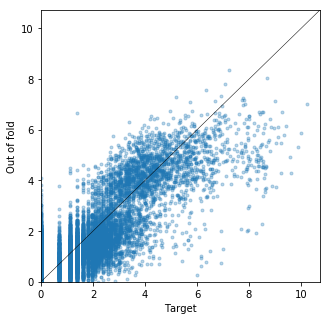

In [39]:
corr1 = train_y1.corr(pd.Series(oof_pred1))
print('corr1 =', corr1)
plot_scatter(train_y1, oof_pred1)

In [40]:
def plot_hist(oof, pred):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.histplot(pred, label='Test Predict', ax=ax, color='black')
    sns.histplot(oof, label='Out of fold', ax=ax, color='C1')
    ax.legend()
    ax.grid()

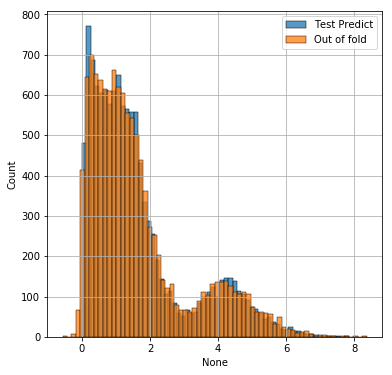

In [41]:
plot_hist(oof_pred1, np.log1p(df_test_pred))

In [42]:
print(f'- feat_cnt = {feat_cnt1}')
print(f'- score = {score1:.5f}')
print(f'- corr = {corr1:.5f}')

- feat_cnt = 203
- score = 1.01014
- corr = 0.82217


#### baseline_15: fit->whole, long_more_titleのみ, titleなし
- feat_cnt = 203
- score = 1.01014
- corr = 0.82217
- LB = 0.968

#### baseline_14: long_more_title(50), title(30)
- feat_cnt = 233
- score = 1.00905
- corr = 0.82265
- LB = 0.9644 ★best★

#### baseline_13: title
- feat_cnt = 203
- score = 1.01047
- corr = 0.82207
- LB = 0.9657

#### baseline_12: description
- feat_cnt = 153
- score = 1.01823
- corr = 0.81906
- LB = 0.9804

#### baseline_11: principal_maker, maker
- feat_cnt = 103
- score = 1.03405
- corr = 0.81277
- LB = 1.0012

#### baseline_10-1: tuning
- feat_cnt = 96
- score = 1.03211
- corr = 0.81355
- LB = 1.0026

#### tuning_10:
- feat_cnt = 96
- score = 1.02586
- corr = 0.81605

#### baseline_9-1: TE n_split=5に戻す, testにしかいないprincipal_makerは別モデル
- feat_cnt = 96, 92
- score = 1.03494, 1.05633
- corr = 0.81246, 0.80358
- LB = 1.0732

#### baseline_8: TE n_split=100
- feat_cnt = 96
- score = 1.00019
- corr = 0.82619
- LB = 1.0166

#### baseline_7: TE_principal_maker, TE_principal_or_first_maker
- feat_cnt = 96
- score = 1.03494
- corr = 0.81246
- LB = 1.0083

#### baseline_6: StratifiedKFold(n_splits=5)
- feat_cnt = 94
- score = 1.04358
- corr = 0.80887
- LB = 1.0219

#### baseline_5: dimension, area, country
- feat_cnt = 94
- score = 1.04760
- corr = 0.80725
- LB = 1.0197

#### baseline_4: color_count, categorical_feature
- feat_cnt = 75
- score = 1.05437
- corr = 0.80446
- LB = 1.0223

#### baseline_3: main_color
- feat_cnt = 73
- score = 1.06423
- corr = 0.80027
- LB = 1.0363

#### baseline_2: material, object_collection, place, technique, person
- feat_cnt = 61
- score = 1.07486
- corr = 0.79573
- LB = 1.0525

#### baseline_1: size, string_length
- feat_cnt = 25
- score = 1.11432
- corr = 0.77827
- LB = 1.1037

#### baseline_0
- feat_cnt = 16
- score = 1.20651
- corr = 0.73332
- LB = 1.1827

In [43]:
def visualize_importance(models):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

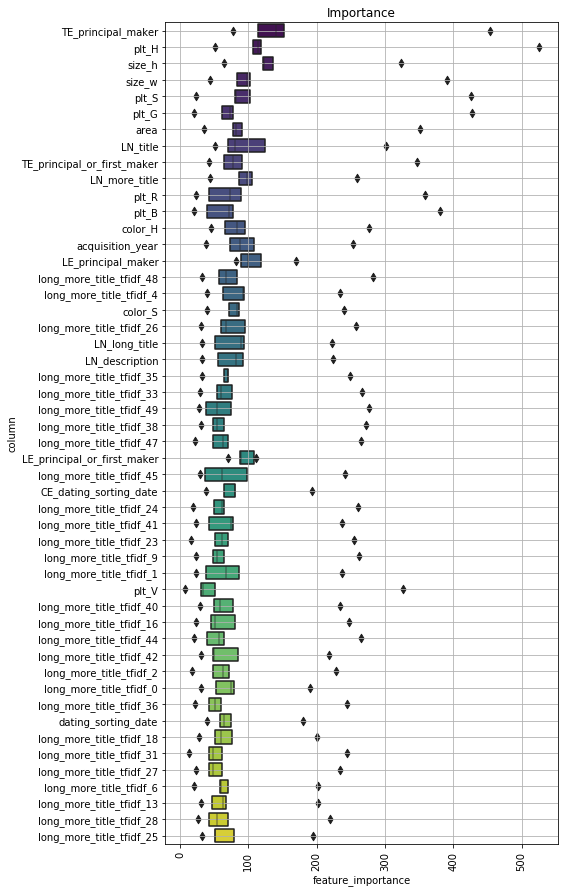

In [44]:
fig, ax = visualize_importance(models1)